# Project setup

## Dependencies

In [1]:
# Cell 0: Installations

# Data ingestion
#%pip install scikit-learn scikit-image
#%pip install SimpleITK
#%pip install nibabel nilearn scipy scikit-image

In [2]:
# Cell 1: Import necessary libraries

# Dataset handling and ingestion
import os
import pandas as pd
import numpy as np

# Image processing
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

# Preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import ndimage
from scipy.ndimage import zoom
from skimage import filters
from skimage.morphology import binary_dilation, binary_erosion, ball
import nibabel as nib

## Dataset loading

In [3]:
# Cell 2: Load and process the CSV file with exam information
csv_path = os.path.join('Images', 'idaSearch.csv')
exam_info_df = pd.read_csv(csv_path)

# Cell 2: Define the base directory and categories
base_dir = 'Images'
categories = ['PPMI_Images_PD', 'PPMI_Images_SWEDD', 'PPMI_Images_Cont']

In [4]:
# Cell 3: Collect DICOM file paths for each category
data = []

for category in categories:
    category_path = os.path.join(base_dir, category)
    for patient_id in os.listdir(category_path):
        patient_path = os.path.join(category_path, patient_id)
        reconstructed_path = os.path.join(patient_path, 'Reconstructed_DaTSCAN')
        if os.path.exists(reconstructed_path):
            for exam_date in os.listdir(reconstructed_path):
                exam_date_path = os.path.join(reconstructed_path, exam_date)
                for exam_id in os.listdir(exam_date_path):
                    exam_id_path = os.path.join(exam_date_path, exam_id)
                    for root, dirs, files in os.walk(exam_id_path):
                        for file in files:
                            if file.endswith('.dcm'):
                                file_path = os.path.join(root, file)
                                # Controlliamo che non sia un'immagine raw
                                if 'br_raw_' not in file_path:
                                    data.append({
                                        'category': category,
                                        'patient_id': patient_id,
                                        'file_path': file_path
                                    })

In [5]:
# Cell 4: Create a DataFrame to organize the data
df = pd.DataFrame(data)
df['label'] = df['category'].map({
    'PPMI_Images_PD': 'PD',
    'PPMI_Images_SWEDD': 'SWEDD',
    'PPMI_Images_Cont': 'Control'
})
df = df[['patient_id', 'file_path', 'label']]

loaded_patients = df['patient_id'].unique()
print("\nLoading statistics:")
print(f"Total unique patients loaded: {len(loaded_patients)}")
print(f"Patients loaded per category:")
for category in df['label'].unique():
    cat_patients = df[df['label'] == category]['patient_id'].nunique()
    print(f"- {category}: {cat_patients} patients")


Loading statistics:
Total unique patients loaded: 1651
Patients loaded per category:
- PD: 1283 patients
- SWEDD: 79 patients
- Control: 289 patients


In [6]:
# Cell 5: Summary statistics
print('Number of images per category:')
print(df['label'].value_counts())
print('\nNumber of unique patients per category:')
for label in df['label'].unique():
    n_patients = df[df['label'] == label]['patient_id'].nunique()
    print(f"{label}: {n_patients} patients")


Number of images per category:
label
PD         2555
Control     294
SWEDD       137
Name: count, dtype: int64

Number of unique patients per category:
PD: 1283 patients
SWEDD: 79 patients
Control: 289 patients


In [7]:
# Cell 6: Save DataFrame to CSV (optional)
df.to_csv('dicom_file_paths.csv', index=False)

In [8]:
# Cell 7: Functions to load and preprocess DICOM images
def load_dicom_image(file_path, target_shape=None):
    """
    Load a DICOM file and return the image data as a NumPy array.
    Optionally resizes the image to the target_shape.
    """
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array.astype(np.float32)
    
    # Apply rescale slope and intercept if present
    if 'RescaleSlope' in ds:
        img *= float(ds.RescaleSlope)
    if 'RescaleIntercept' in ds:
        img += float(ds.RescaleIntercept)
    
    # Normalize the image intensities
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # Resize image if target_shape is specified
    if target_shape and img.shape != target_shape:
        from skimage.transform import resize
        img = resize(img, target_shape, mode='reflect', anti_aliasing=True)
    
    return img

def print_dicom_orientation(dicom_path):
    """
    Stampa le informazioni di orientamento dal file DICOM
    """
    ds = pydicom.dcmread(dicom_path)
    print("\nDICOM Orientation Info:")
    for tag in ['ImageOrientationPatient', 'ImagePositionPatient', 'PixelSpacing']:
        if tag in ds:
            print(f"{tag}: {ds[tag].value}")

def debug_volume_visualization(mean_img, title="Debug Volume View"):
    """
    Visualize the 3D volume more appropriately for DATSCAN

    Visualizza il volume 3D in modo più appropriato per DATSCAN
    """
    print(f"Volume shape: {mean_img.shape}")
    
    # Extract the central planes in three directions
    center_x = mean_img.shape[0] // 2
    center_y = mean_img.shape[1] // 2
    center_z = mean_img.shape[2] // 2
    
    # Visualize raw data without manipulations
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"{title} - Raw Data Views")
    
    # First row: raw data
    axes[0,0].imshow(mean_img[center_x, :, :], cmap='gray')
    axes[0,0].set_title('YZ plane (raw)')
    axes[0,1].imshow(mean_img[:, center_y, :], cmap='gray')
    axes[0,1].set_title('XZ plane (raw)')
    axes[0,2].imshow(mean_img[:, :, center_z], cmap='gray')
    axes[0,2].set_title('XY plane (raw)')
    
    # Second row: histograms intensity distributions
    axes[1,0].hist(mean_img[center_x, :, :].ravel(), bins=50)
    axes[1,0].set_title('YZ intensity distribution')
    axes[1,1].hist(mean_img[:, center_y, :].ravel(), bins=50)
    axes[1,1].set_title('XZ intensity distribution')
    axes[1,2].hist(mean_img[:, :, center_z].ravel(), bins=50)
    axes[1,2].set_title('XY intensity distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Some statistics
    print("\nStatistics per plane:")
    print(f"YZ plane - min: {mean_img[center_x, :, :].min():.3f}, max: {mean_img[center_x, :, :].max():.3f}")
    print(f"XZ plane - min: {mean_img[:, center_y, :].min():.3f}, max: {mean_img[:, center_y, :].max():.3f}")
    print(f"XY plane - min: {mean_img[:, :, center_z].min():.3f}, max: {mean_img[:, :, center_z].max():.3f}")

    return mean_img

In [9]:
# Cell 8: Initialize dictionaries to store sums and counts for each group
mean_sums = {'PD': None, 'SWEDD': None, 'Control': None}
counts = {'PD': 0, 'SWEDD': 0, 'Control': 0}
shapes = {'PD': None, 'SWEDD': None, 'Control': None}


In [10]:
# Cell 9: Compute mean images for each group
# We'll iterate over the DataFrame 'df' created earlier

# Map labels to group names
group_labels = {'PD': 'PD', 'SWEDD': 'SWEDD', 'Control': 'Control'}

# Iterate over each group
for label in group_labels.values():
    group_df = df[df['label'] == label]
    print(f"Processing group: {label}")
    
    # Initialize progress bar
    for idx, row in tqdm(group_df.iterrows(), total=group_df.shape[0]):
        file_path = row['file_path']
        try:
            # Load the image
            if counts[label] == 0:
                # For the first image, get the shape
                img = load_dicom_image(file_path)
                shapes[label] = img.shape
                mean_sums[label] = np.zeros(shapes[label], dtype=np.float32)
            else:
                # For subsequent images, resize if necessary
                img = load_dicom_image(file_path, target_shape=shapes[label])
            
            # Accumulate the sum
            mean_sums[label] += img
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    # Compute the mean
    mean_sums[label] /= counts[label]


Processing group: PD


100%|██████████| 2555/2555 [00:19<00:00, 133.77it/s]


Processing group: SWEDD


100%|██████████| 137/137 [00:01<00:00, 127.57it/s]


Processing group: Control


100%|██████████| 294/294 [00:02<00:00, 138.62it/s]



Single DICOM control analysis:

DICOM Orientation Info:
PixelSpacing: [2.0, 2.0]

Debug visualization for PD group:
Volume shape: (91, 109, 91)


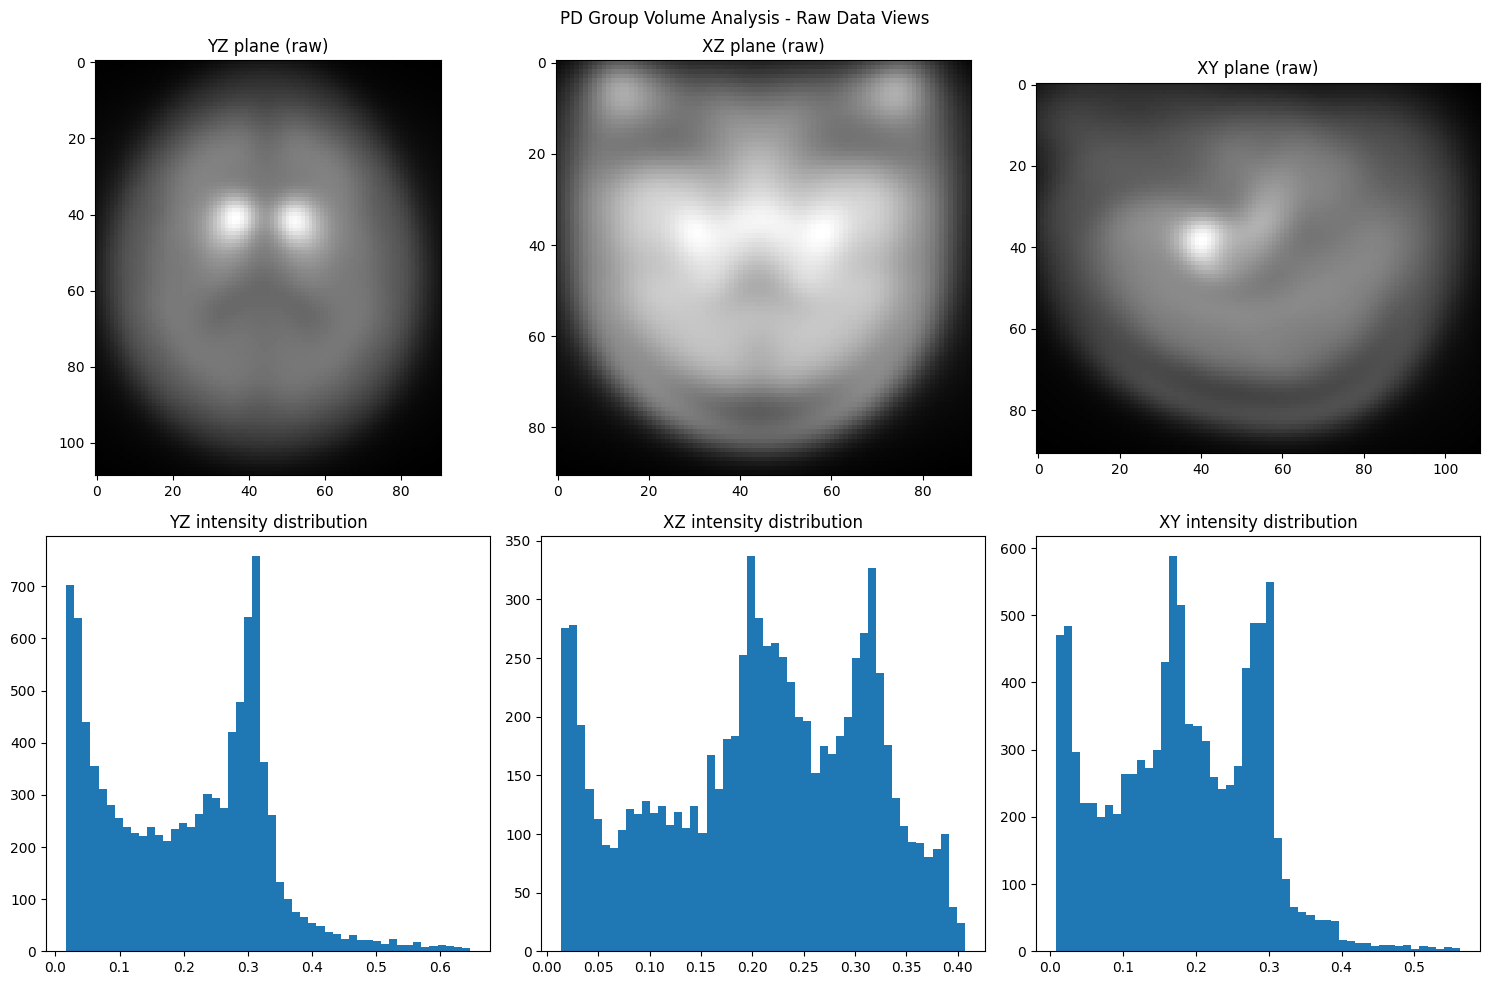


Statistics per plane:
YZ plane - min: 0.017, max: 0.647
XZ plane - min: 0.014, max: 0.407
XY plane - min: 0.008, max: 0.562

Debug visualization for SWEDD group:
Volume shape: (91, 109, 91)


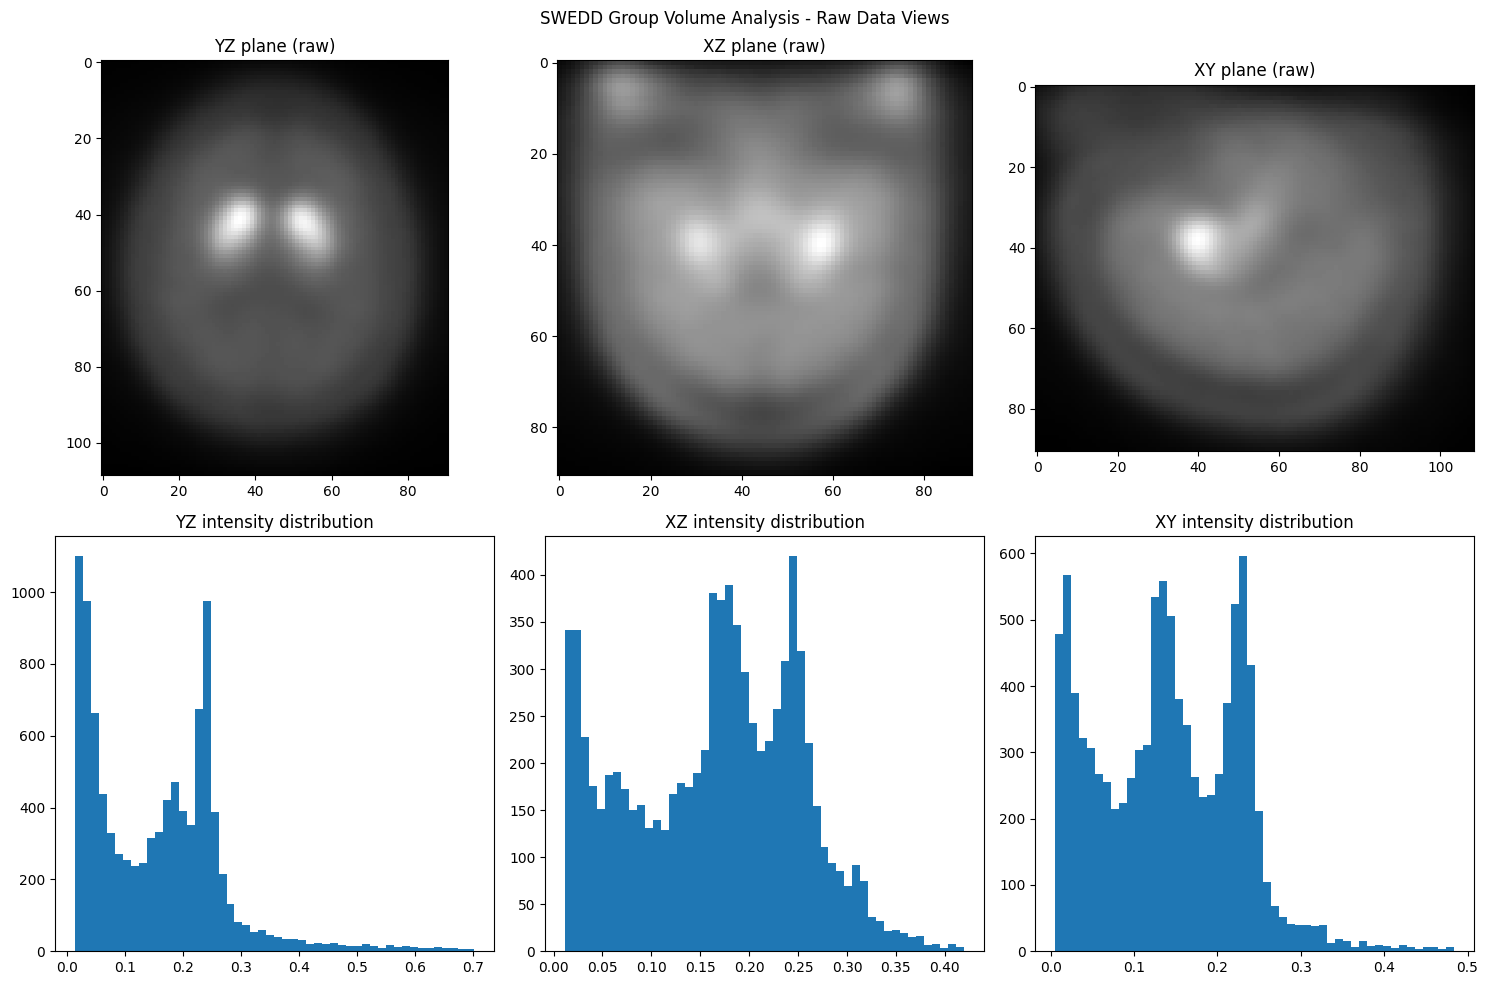


Statistics per plane:
YZ plane - min: 0.013, max: 0.702
XZ plane - min: 0.012, max: 0.420
XY plane - min: 0.005, max: 0.484

Debug visualization for Control group:
Volume shape: (91, 109, 91)


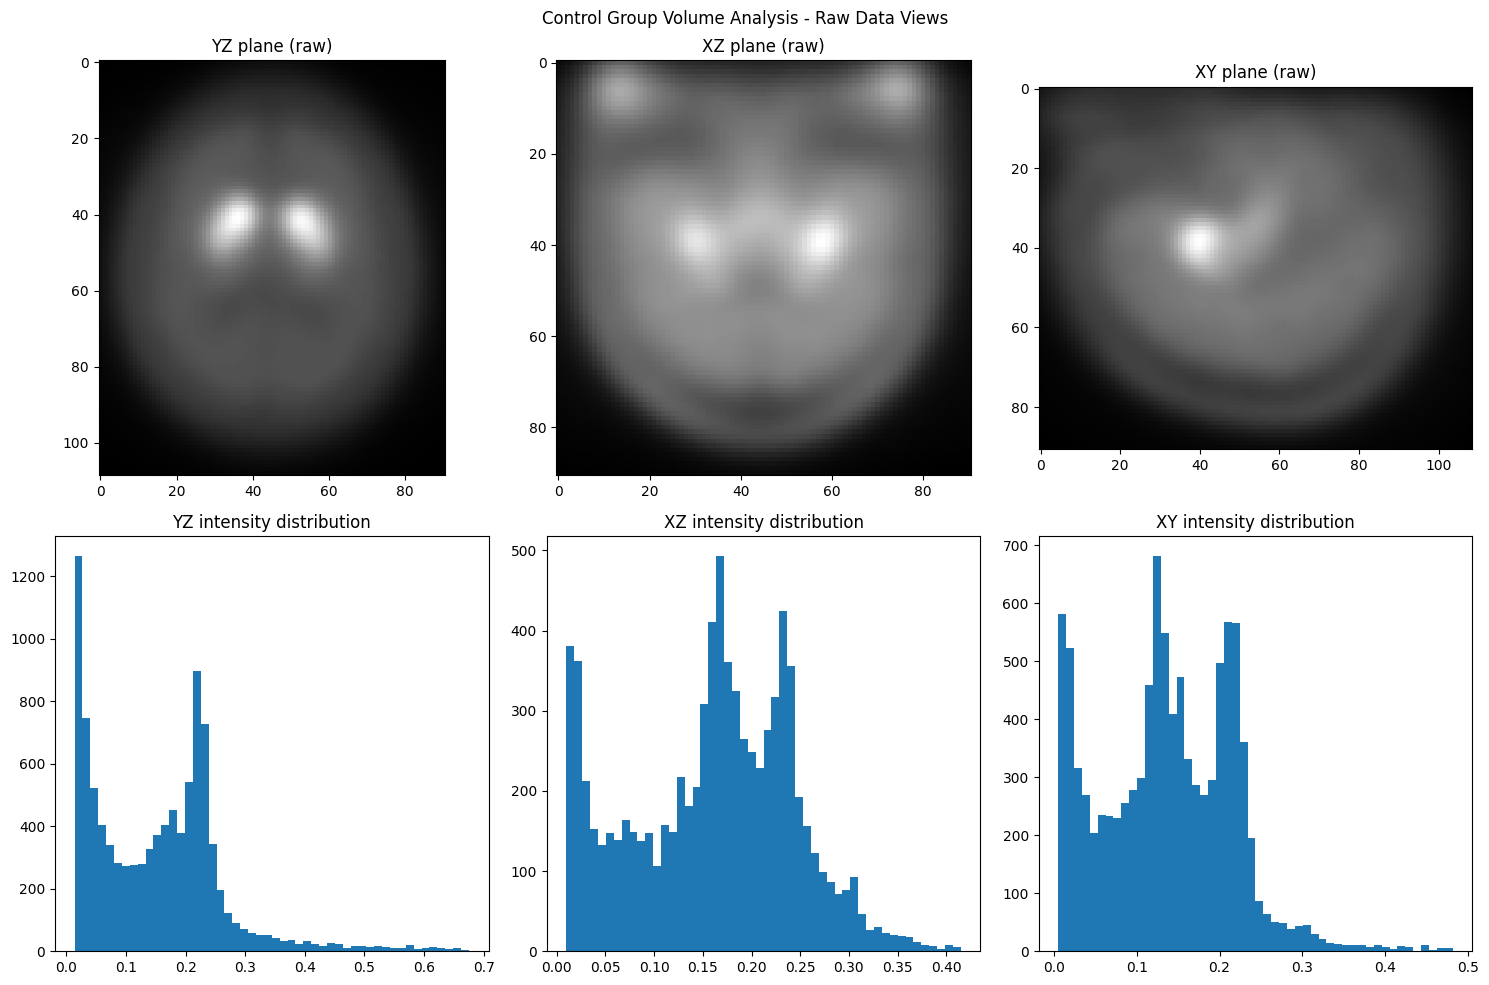


Statistics per plane:
YZ plane - min: 0.014, max: 0.675
XZ plane - min: 0.010, max: 0.415
XY plane - min: 0.005, max: 0.481


In [11]:
# Cell 10: Visualize the mean images and debug information
first_control_file = df[df['label'] == 'Control']['file_path'].iloc[0]
print("\nSingle DICOM control analysis:")
print_dicom_orientation(first_control_file)

# Debug information for each group
for label in ['PD', 'SWEDD', 'Control']:
    print(f"\nDebug visualization for {label} group:")
    debug_volume_visualization(mean_sums[label], title=f"{label} Group Volume Analysis")

In [12]:
# Cell 11: Visualize the mean images for each group with corrected orientation
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_views(mean_img, title_prefix):
    """
    Plots the axial, coronal, and sagittal views of the mean image with corrected orientation.
    Each image is rotated counterclockwise by 90 degrees.
    """
    # Swap axes if necessary to match anatomical planes
    # This rearranges the data from (Z, Y, X) to (X, Y, Z)
    mean_img = np.swapaxes(mean_img, 0, 2)

    # Compute the middle slices
    axial_slice = mean_img[:, :, mean_img.shape[2] // 2]
    coronal_slice = mean_img[:, mean_img.shape[1] // 2, :]
    sagittal_slice = mean_img[mean_img.shape[0] // 2, :, :]

    # Adjust the orientation of slices
    # First, flip slices to correct the orientation
    axial_slice = np.flipud(axial_slice)
    coronal_slice = np.flipud(coronal_slice)
    sagittal_slice = np.flipud(sagittal_slice)

    # Then, rotate each slice counterclockwise by 90 degrees
    axial_slice = np.rot90(axial_slice, k=1)
    coronal_slice = np.rot90(coronal_slice, k=1)
    sagittal_slice = np.rot90(sagittal_slice, k=1)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"{title_prefix} Mean Views")

    axes[0].imshow(axial_slice, cmap='gray', origin='upper')
    axes[0].set_title('Axial View')
    axes[0].axis('off')

    axes[1].imshow(coronal_slice, cmap='gray', origin='upper')
    axes[1].set_title('Coronal View')
    axes[1].axis('off')

    axes[2].imshow(sagittal_slice, cmap='gray', origin='upper')
    axes[2].set_title('Sagittal View')
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


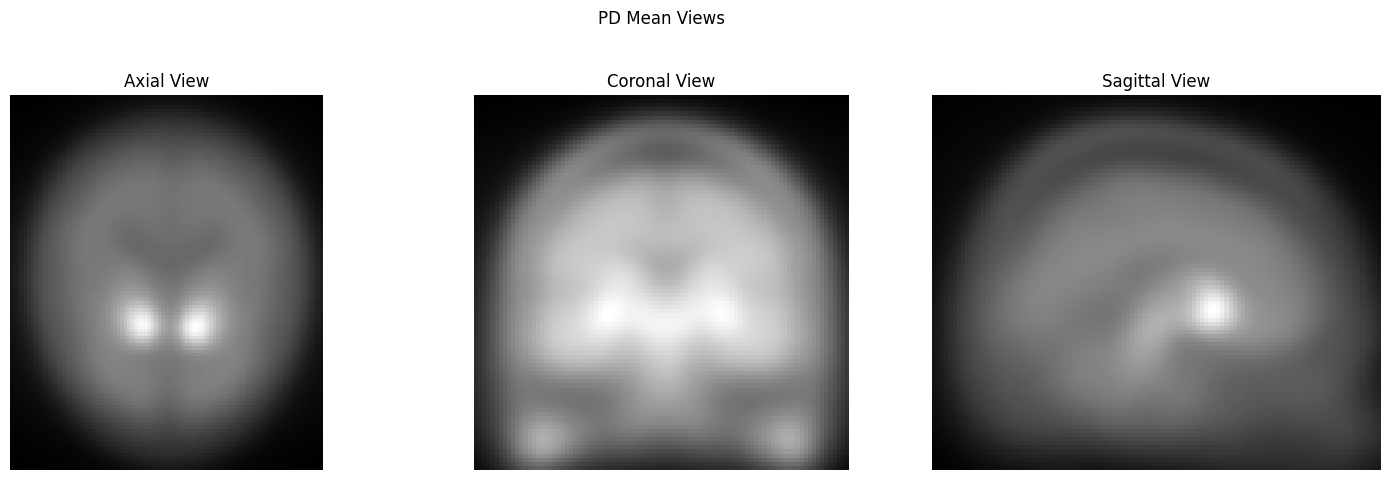

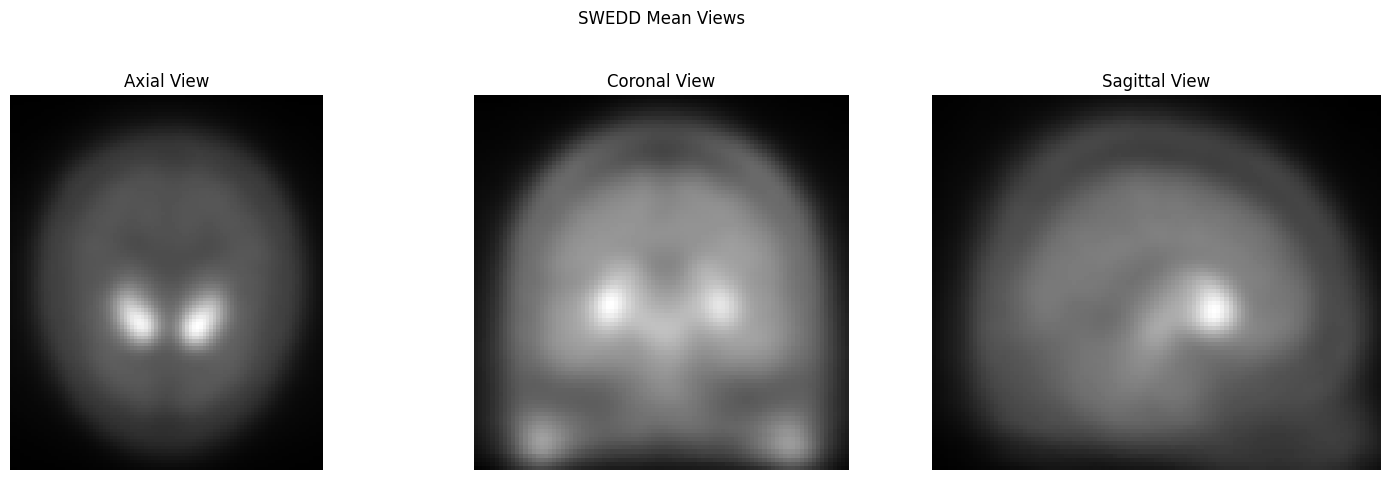

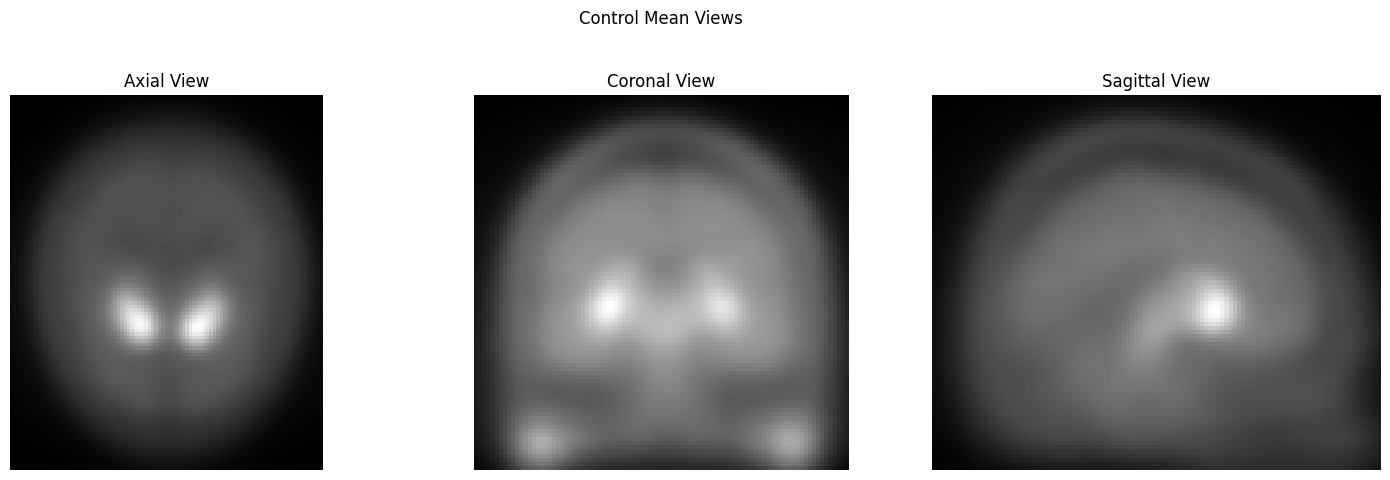

In [13]:
# Cell 12: Plot the mean views for each group
for label in group_labels.values():
    mean_img = mean_sums[label]
    plot_mean_views(mean_img, title_prefix=label)


Selected Random Patients:
PD: Patient ID 181208
SWEDD: Patient ID 3790
Control: Patient ID 102447
Visualizing Patient ID 181208 - File: Images\PPMI_Images_PD\181208\Reconstructed_DaTSCAN\2022-09-08_13_01_17.0\I1665845\PPMI_181208_NM_Reconstructed_DaTSCAN_Br_20230213205123944_1_S1194084_I1665845.dcm


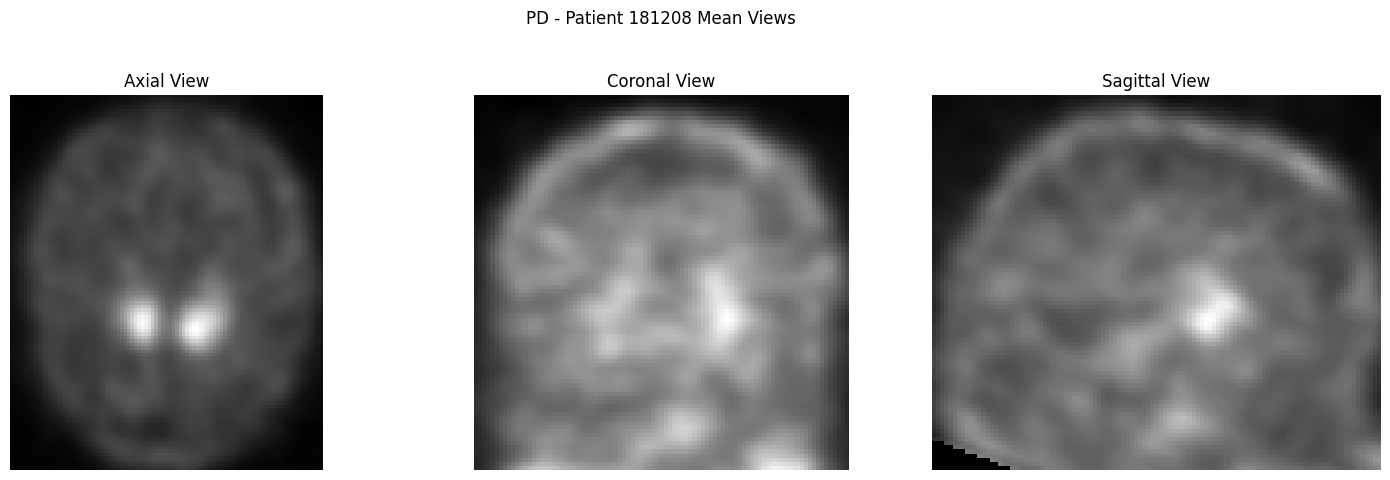

Visualizing Patient ID 3790 - File: Images\PPMI_Images_SWEDD\3790\Reconstructed_DaTSCAN\2012-11-20_14_02_04.0\I360619\PPMI_3790_NM_Reconstructed_DaTSCAN_Br_20130219123623736_1_S182291_I360619.dcm


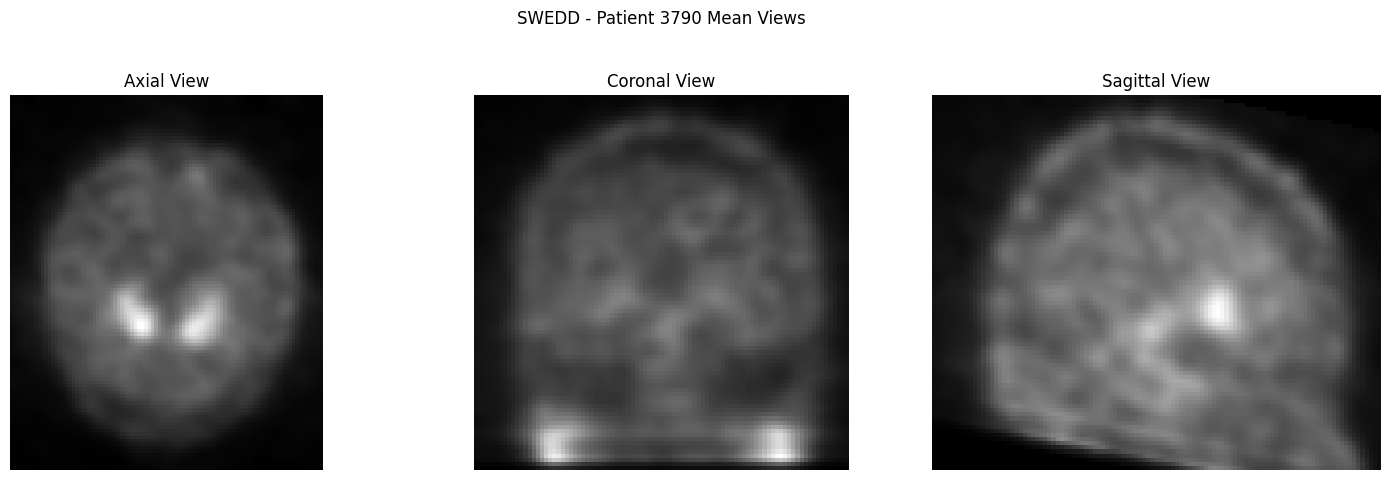

Visualizing Patient ID 102447 - File: Images\PPMI_Images_Cont\102447\Reconstructed_DaTSCAN\2021-07-29_13_33_45.0\I1509527\PPMI_102447_NM_Reconstructed_DaTSCAN_Br_20211028123141599_1_S1076695_I1509527.dcm


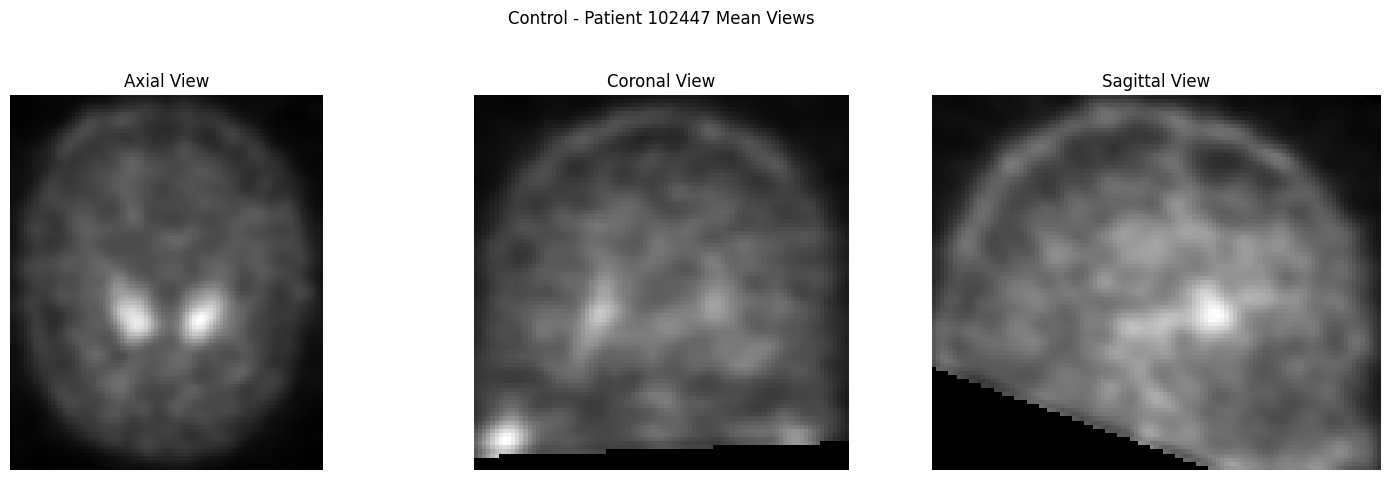

In [14]:
# Cell 13: Select and visualize a random patient from each group

import random

# Function to select a random patient from each group
def select_random_patients(df, groups):
    random_patients = {}
    for group in groups:
        group_df = df[df['label'] == group]
        unique_patients = group_df['patient_id'].unique()
        if len(unique_patients) == 0:
            print(f"No patients found in group: {group}")
            continue
        selected_patient = random.choice(unique_patients)
        random_patients[group] = selected_patient
    return random_patients

# Define the groups
groups = ['PD', 'SWEDD', 'Control']

# Select random patients
random_patients = select_random_patients(df, groups)
print("Selected Random Patients:")
for group, patient in random_patients.items():
    print(f"{group}: Patient ID {patient}")

    # Function to visualize a random image for a given patient
def visualize_random_patient(df, patient_id, label):
    """
    Select a random DICOM file for the given patient and plot its views.
    """
    patient_df = df[(df['patient_id'] == patient_id) & (df['label'] == label)]
    if patient_df.empty:
        print(f"No images found for Patient ID {patient_id} in group {label}.")
        return
    
    # Select a random image
    random_file = random.choice(patient_df['file_path'].tolist())
    print(f"Visualizing Patient ID {patient_id} - File: {random_file}")
    
    # Load the image
    img = load_dicom_image(random_file)
    
    # Plot the views
    plot_mean_views(img, title_prefix=f"{label} - Patient {patient_id}")

# Iterate over each group and visualize a random patient
for group, patient_id in random_patients.items():
    visualize_random_patient(df, patient_id, group)

## EDA

In [15]:
# Cell 14: Configure GPU settings and memory monitoring
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def get_memory_usage():
    """
    Get current memory usage of the system and GPU if available
    """
    # System memory
    process = psutil.Process()
    system_memory = process.memory_info().rss / 1024 / 1024  # MB
    
    # GPU memory
    gpu_memory = None
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.memory_allocated() / 1024 / 1024  # MB
    
    return system_memory, gpu_memory

if torch.cuda.is_available():
    # Print GPU info
    print(f"GPU Name: {torch.cuda.get_device_name()}")
    print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Set memory management options
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4070 Ti
GPU Memory Available: 12.88 GB


In [16]:
# Cell 15: Enhanced image statistics computation with memory tracking
def compute_image_statistics(img):
    """
    Compute comprehensive statistics for a 3D image
    """
    stats_dict = {
        'mean': float(np.mean(img)),  # Convert to native Python types
        'std': float(np.std(img)),
        'min': float(np.min(img)),
        'max': float(np.max(img)),
        'median': float(np.median(img)),
        'skewness': float(stats.skew(img.flatten())),
        'kurtosis': float(stats.kurtosis(img.flatten())),
        'num_zeros': int(np.sum(img == 0)),
        'num_non_zeros': int(np.sum(img != 0)),
        'volume': int(img.size),
        'dimensions': img.shape
    }
    
    # Compute histogram data
    hist, bins = np.histogram(img.flatten(), bins=50)
    stats_dict['histogram'] = {
        'counts': hist.tolist(),  # Convert to list for better memory management
        'bins': bins.tolist()
    }
    
    return stats_dict

In [17]:
# Cell 16: Batch process images with improved memory management
def process_group_statistics(group_df, batch_size=5):
    """
    Process images in batches with memory monitoring
    """
    statistics = []
    
    # Create progress bar for the entire dataset
    with tqdm(total=len(group_df), desc="Processing images") as pbar:
        for start_idx in range(0, len(group_df), batch_size):
            end_idx = min(start_idx + batch_size, len(group_df))
            batch_df = group_df.iloc[start_idx:end_idx]
            
            for _, row in batch_df.iterrows():
                try:
                    img = load_dicom_image(row['file_path'])
                    stats = compute_image_statistics(img)
                    stats['patient_id'] = row['patient_id']
                    statistics.append(stats)
                    del img
                except Exception as e:
                    tqdm.write(f"Error processing {row['file_path']}: {e}")
                
                pbar.update(1)
            
            # Clean up memory after batch
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    return statistics

In [18]:
# Cell 17: Process statistics for each group with progress tracking
group_statistics = {}
for label in group_labels.values():
    print(f"\nProcessing statistics for {label} group...")
    start_time = time.time()
    
    group_df = df[df['label'] == label]
    group_statistics[label] = process_group_statistics(group_df)
    
    duration = time.time() - start_time
    print(f"Completed {label} group in {duration:.2f} seconds")
    print(f"Processed {len(group_statistics[label])} images")


Processing statistics for PD group...


NameError: name 'time' is not defined

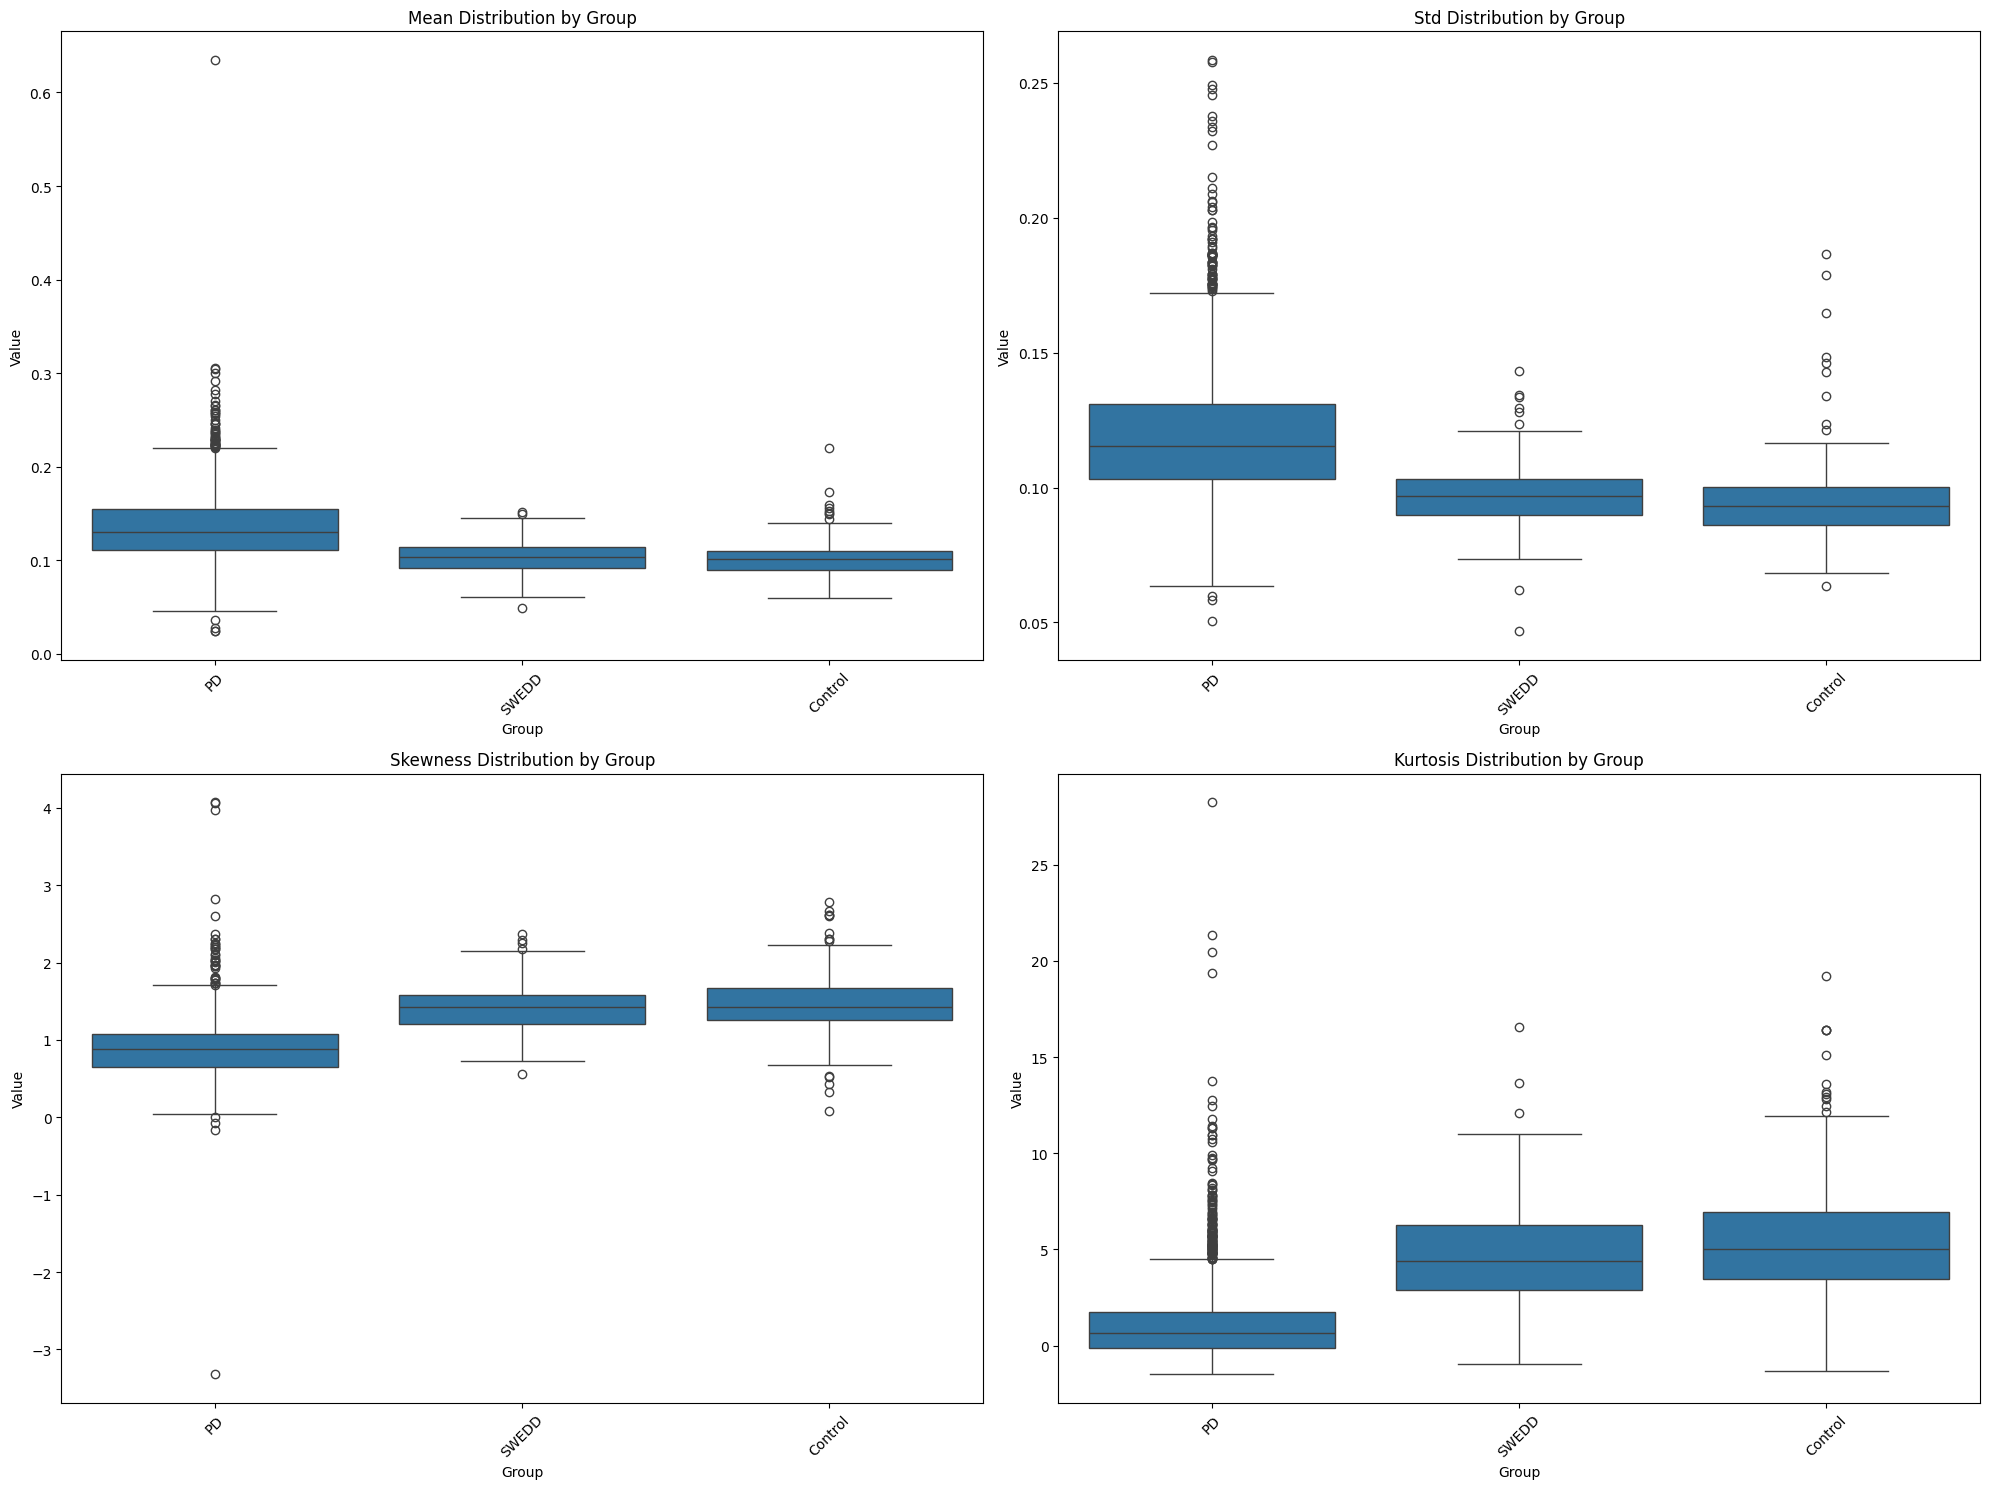

In [ ]:
# Cell 18: Visualize statistical distributions with efficient memory usage
def plot_group_statistics(group_statistics):
    """
    Create comparison plots for different statistical measures across groups
    """
    metrics = ['mean', 'std', 'skewness', 'kurtosis']
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    for idx, (metric, ax) in enumerate(zip(metrics, axes.flatten())):
        plot_data = []
        group_names = []
        
        for group in group_labels.values():
            values = [s[metric] for s in group_statistics[group]]
            plot_data.extend(values)
            group_names.extend([group] * len(values))
        
        # Create DataFrame for seaborn
        import pandas as pd
        df_plot = pd.DataFrame({
            'Group': group_names,
            'Value': plot_data
        })
        
        # Create boxplot using the correct syntax
        sns.boxplot(data=df_plot, x='Group', y='Value', ax=ax)
        ax.set_title(f'{metric.capitalize()} Distribution by Group')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Clean up
    plt.close('all')
    gc.collect()

plot_group_statistics(group_statistics)

### Intensity distributions analysis by Group

**Mean Distribution by Group**

The average intensity values of voxels in the brain scans for each group (PD, SWEDD, Control).

- **Higher means** indicate brighter regions overall in the scan.
  - In DAT scans, this is particularly important because dopamine transporters show up as bright areas.
  - **Lower mean values** in PD patients often indicate loss of dopamine transporters.
  - SWEDD patients (Scans Without Evidence of Dopaminergic Deficit) should show values more similar to controls.
- The box shows where **50% of data** falls, with the middle line being the **median**.
- Whiskers show the range of "normal" values, and dots are **outliers**.

**Standard Deviation (Std) Distribution by Group**

How much variation or dispersion exists in the voxel intensities.

- **Higher std** means more contrast between different regions in the brain.
- **Lower std** suggests more uniform intensity across the scan.
- In PD patients:
  - Lower std may reflect loss of the normally bright dopamine transporter regions.
- **Controls** should show higher std due to clear distinction between regions with and without dopamine transporters.
- **SWEDD patients** should be similar to controls in this measure.

**Skewness Distribution by Group**

The asymmetry of the intensity distribution.

- **Positive skewness** (value > 0) means there's a long tail of high values.
- **Negative skewness** (value < 0) means there's a long tail of low values.
- In DAT scans:
  - **Controls** often show positive skewness due to the presence of bright dopamine transporter regions.
  - **PD patients** might show less positive skewness due to loss of these bright regions.
  - **SWEDD** should be similar to controls.
- This measure can help identify patterns in how the disease affects certain brain regions.

**Kurtosis Distribution by Group**

The "tailedness" of the intensity distribution.

- **Higher kurtosis** means more extreme values (outliers).
- **Lower kurtosis** means the data is more uniformly distributed.
- In DAT scans:
  - **Controls** might show higher kurtosis due to the distinct contrast between regions.
  - **PD patients** might show lower kurtosis due to more uniform (and reduced) signal.
  - **SWEDD patients** should again be more similar to controls.
- This can help identify how distinct the dopamine transporter regions are from background tissue.

In [ ]:
# Cell 20: Analyze spatial characteristics with memory optimization
def compute_spatial_features(img):
    """
    Analyze spatial characteristics of 3D images with memory optimization
    """
    # Compute gradients one at a time to save memory
    gradients = []
    for axis in range(3):
        grad = np.gradient(img, axis=axis)
        gradients.append(grad)
        
    gradient_magnitude = np.sqrt(sum(grad**2 for grad in gradients))
    del gradients  # Free memory
    
    # Compute edge information using Sobel
    from scipy import ndimage
    edges = []
    for axis in range(3):
        edge = ndimage.sobel(img, axis=axis)
        edges.append(edge**2)
    
    edge_magnitude = np.sqrt(sum(edges))
    del edges  # Free memory
    
    # Compute statistics
    spatial_stats = {
        'gradient_stats': compute_image_statistics(gradient_magnitude),
        'edge_stats': compute_image_statistics(edge_magnitude)
    }
    
    # Clean up
    del gradient_magnitude, edge_magnitude
    gc.collect()
    
    return spatial_stats

In [ ]:
# Cell 21: Analyze ROI characteristics with memory efficiency
def analyze_roi_characteristics(img, threshold=0.5):
    """
    Analyze characteristics of regions of interest with memory optimization
    """
    # Create binary mask
    binary_mask = img > threshold
    del img  # Free original image memory if not needed
    
    # Label connected components
    labeled_array, num_features = ndimage.label(binary_mask)
    del binary_mask  # Free binary mask memory
    
    roi_properties = {
        'num_regions': num_features,
        'volumes': [],
        'centroids': [],
        'mean_intensities': []
    }
    
    # Process each ROI
    for label in range(1, num_features + 1):
        region_mask = labeled_array == label
        roi_properties['volumes'].append(int(np.sum(region_mask)))
        roi_properties['centroids'].append(tuple(map(float, ndimage.center_of_mass(region_mask))))
        roi_properties['mean_intensities'].append(float(np.mean(img[region_mask])))
        del region_mask  # Free mask memory after each iteration
    
    del labeled_array  # Free labeled array memory
    gc.collect()
    
    return roi_properties

In [ ]:
# Cell 22: Visualize ROI distribution with batch processing
def plot_roi_distributions(group_statistics):
    plt.figure(figsize=(15, 5))
    
    for idx, (group, stats) in enumerate(group_statistics.items()):
        roi_volumes = []
        
        # Process in smaller batches
        batch_size = 10
        for i in range(0, len(stats), batch_size):
            batch_stats = stats[i:i + batch_size]
            
            for stat in batch_stats:
                img = load_dicom_image(df[df['patient_id'] == stat['patient_id']].iloc[0]['file_path'])
                roi_props = analyze_roi_characteristics(img)
                roi_volumes.extend(roi_props['volumes'])
                del img, roi_props
                gc.collect()
        
        plt.subplot(1, 3, idx+1)
        sns.histplot(roi_volumes, bins=30)
        plt.title(f'ROI Volume Distribution - {group}')
        plt.xlabel('Volume (voxels)')
        plt.ylabel('Count')
        
        del roi_volumes
        gc.collect()
    
    plt.tight_layout()
    plt.show()
    plt.close('all')

In [ ]:
# Cell 23: Save processed statistics with compression
import pickle
import gzip

# Save statistics to compressed file for better storage
with gzip.open('group_statistics.pkl.gz', 'wb') as f:
    pickle.dump(group_statistics, f)

In [ ]:
# Cell 24: Print summary report
print("\nEDA Summary Report")
print("-----------------")
for group, stats in group_statistics.items():
    print(f"\n{group} Group:")
    print(f"Number of samples: {len(stats)}")
    
    # Calculate aggregate statistics
    means = np.mean([s['mean'] for s in stats])
    stds = np.mean([s['std'] for s in stats])
    skew = np.mean([s['skewness'] for s in stats])
    kurt = np.mean([s['kurtosis'] for s in stats])
    
    print(f"Average intensity: {means:.2f} ± {stds:.2f}")
    print(f"Average skewness: {skew:.2f}")
    print(f"Average kurtosis: {kurt:.2f}")


EDA Summary Report
-----------------

PD Group:
Number of samples: 2555
Average intensity: 0.13 ± 0.12
Average skewness: 0.88
Average kurtosis: 1.11

SWEDD Group:
Number of samples: 137
Average intensity: 0.10 ± 0.10
Average skewness: 1.42
Average kurtosis: 4.73

Control Group:
Number of samples: 294
Average intensity: 0.10 ± 0.09
Average skewness: 1.49
Average kurtosis: 5.57


### EDA Overview Report

**Dataset Composition**
The analysis encompasses a total of 2,986 DATSCAN images distributed across three groups:
- Parkinson's Disease (PD): 2,555 samples (85.6%)
- SWEDD: 137 samples (4.6%)
- Control: 294 samples (9.8%)

It's worth noting that there is a significant class imbalance in the dataset, with PD cases representing the vast majority of the samples. This imbalance should be considered during model development and validation phases.

**Intensity Analysis**

***Average Intensities (μ ± σ)***
- PD Group: 0.13 ± 0.12
- SWEDD Group: 0.10 ± 0.10
- Control Group: 0.10 ± 0.09

The intensity patterns reveal several interesting findings:
1. PD patients show slightly higher average intensity (0.13) compared to other groups, which is somewhat counterintuitive as we would typically expect lower dopamine transporter activity in PD patients. This might suggest:
   - Potential compensation mechanisms in the brain
   - Variations in image acquisition or normalization
   - The need for region-specific analysis rather than global intensity measurements

2. SWEDD and Control cases show identical average intensities (0.10), which:
   - Aligns with the clinical presentation of SWEDD cases showing no evidence of dopaminergic deficit
   - Suggests that simple intensity measures alone may not be sufficient to distinguish between these groups
   - Indicates the need for more sophisticated analysis methods

**Distribution Characteristics:**

***Skewness Analysis***
- PD Group: 0.88
- SWEDD Group: 1.42
- Control Group: 1.49

The skewness values offer valuable insights:
1. All groups show positive skewness, indicating right-tailed distributions (more low-intensity values with a tail toward higher intensities)
2. SWEDD and Control groups show notably higher skewness (1.42 and 1.49 respectively) compared to PD (0.88)
3. This pattern suggests:
   - More uniform intensity distribution in PD cases, possibly due to loss of contrast in dopamine transporter regions
   - Similar intensity patterns between SWEDD and Control groups, supporting their clinical similarity
   - Potential biomarker patterns in the intensity distribution shape

***Kurtosis Analysis***
- PD Group: 1.11
- SWEDD Group: 4.73
- Control Group: 5.57

The kurtosis values reveal striking differences:
1. PD cases show markedly lower kurtosis (1.11) compared to both other groups
2. Control group shows the highest kurtosis (5.57), followed closely by SWEDD cases (4.73)
3. These patterns indicate:
   - More uniform intensity distribution in PD cases (closer to mesokurtic)
   - More extreme values in both SWEDD and Control cases (highly leptokurtic)
   - Potential loss of distinct dopamine transporter regions in PD cases

**Clinical Implications**
These statistical findings have several important implications for clinical practice and research:

1. *Diagnostic Potential*:
   - The distinct kurtosis values between PD and non-PD cases suggest potential diagnostic value
   - The similarity in intensity and distribution patterns between SWEDD and Control cases explains the challenge in clinical differentiation

2. *Group Characteristics*:
   - PD cases show more uniform intensity distributions (lower skewness and kurtosis)
   - SWEDD and Control cases show more varied distributions with more extreme values
   - The slight intensity difference in PD cases might represent a compensatory mechanism

3. *Future Directions*:
   - Region-specific analysis might reveal more detailed patterns
   - Machine learning models should consider these distribution characteristics
   - The class imbalance should be addressed in model development
   - Investigation of the biological basis for the intensity patterns in PD cases

# Preprocessing

In [ ]:
# Cell 25: Import necessary libraries with memory monitoring
import os
import numpy as np
import torch
import torch.nn.functional as F
from scipy.ndimage import zoom
from skimage import exposure
from tqdm import tqdm
import psutil
import gc

def get_memory_info():
    """Monitor both system and GPU memory"""
    gpu_memory = f"{torch.cuda.memory_allocated()/1024**2:.2f}MB" if torch.cuda.is_available() else "N/A"
    system_memory = f"{psutil.Process().memory_info().rss/1024**2:.2f}MB"
    return f"System Memory: {system_memory}, GPU Memory: {gpu_memory}"

In [ ]:
# Cell 26: Create DataLoader for memory-efficient processing
class DATSCANDataset(Dataset):
    def __init__(self, file_paths, labels=None, target_shape=(128, 128, 128), transforms=None):
        self.file_paths = file_paths
        self.labels = labels
        self.target_shape = target_shape
        self.transforms = transforms

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        try:
            # Load and preprocess single image
            img = load_dicom_image(self.file_paths[idx])
            img = self.preprocess_single_image(img)

            # Ensure 3D shape
            if len(img.shape) != 3:
                raise ValueError(f"Expected 3D image, got shape {img.shape}")

            # Add channel dimension and convert to tensor
            img_tensor = torch.FloatTensor(img).unsqueeze(0)  # Add channel dimension

            if self.labels is not None:
                return img_tensor, self.labels[idx]
            return img_tensor

        except Exception as e:
            print(f"\nError processing image {self.file_paths[idx]}: {str(e)}")
            # Return zero tensor with correct shape
            return torch.zeros((1,) + self.target_shape)

    def extract_brain(self, img):
        """
        Extract brain region using thresholding and morphological operations
        Specifically adapted for DATSCAN images focusing on striatal regions
        """
        # Otsu's thresholding to separate brain from background
        thresh = filters.threshold_otsu(img)
        binary_mask = img > thresh

        # Remove small objects and fill holes
        binary_mask = ndimage.binary_opening(binary_mask, structure=ball(2))
        binary_mask = ndimage.binary_closing(binary_mask, structure=ball(2))
        
        # Fill holes in the mask
        binary_mask = ndimage.binary_fill_holes(binary_mask)
        
        # Focus on central region where striatum is typically located
        center_z = binary_mask.shape[2] // 2
        z_range = slice(center_z - 20, center_z + 20)  # Adjust range based on your data
        
        # Create striatal region mask
        striatal_mask = np.zeros_like(binary_mask)
        striatal_mask[:, :, z_range] = binary_mask[:, :, z_range]
        
        # Apply the mask to the original image
        masked_img = img * striatal_mask
        
        return masked_img

    def spatial_normalization(self, img):
        """
        Apply spatial normalization with correct orientation for DATSCAN
        """
        # First, transpose the image to correct orientation
        img = np.transpose(img, (1, 0, 2))
        
        # Center the image based on center of mass
        center_of_mass = ndimage.center_of_mass(img)
        shifts = [s//2 - c for s, c in zip(img.shape, center_of_mass)]
        img = ndimage.shift(img, shifts, mode='constant')
        
        # Ensure the striatum is centered in axial view
        # Find the maximum intensity slice in axial view
        axial_sums = np.sum(img, axis=(0, 1))
        max_slice = np.argmax(axial_sums)
        desired_z = img.shape[2] // 2
        z_shift = desired_z - max_slice
        
        if abs(z_shift) > 0:
            img = ndimage.shift(img, (0, 0, z_shift), mode='constant')
        
        return img

    def preprocess_single_image(self, img):
        """Enhanced preprocessing pipeline specifically for DATSCAN images"""
        try:
            # 1. Convert to float32 for processing
            img = img.astype(np.float32)
            
            # 2. Initial denoising
            img = ndimage.gaussian_filter(img, sigma=0.5)
            
            # 3. Brain extraction focusing on striatal regions
            img = self.extract_brain(img)
            
            # 4. Spatial normalization
            img = self.spatial_normalization(img)
            
            # 5. Enhanced normalization using percentile clipping
            p2, p98 = np.percentile(img[img > 0], (2, 98))  # Only consider non-zero values
            img = np.clip(img, p2, p98)
            img = (img - p2) / (p98 - p2)
            
            # 6. Resize with consistent aspect ratio
            if img.shape != self.target_shape:
                resize_factors = [t/s for t, s in zip(self.target_shape, img.shape)]
                img = zoom(img, resize_factors, order=1, mode='reflect')
            
            # 7. Additional augmentations if specified
            if self.transforms:
                img = self.transforms(img)
            
            # 8. Final normalization to [0,1] range
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            
            return img
            
        except Exception as e:
            raise ValueError(f"Error in preprocessing: {str(e)}")

In [ ]:
# Cell 26.5: Data Augmentation for DATSCAN Images

import torchvision.transforms as transforms
import random
import numbers
from scipy.ndimage import rotate

class RandomRotation3D:
    def __init__(self, degrees=10, axis=(0,1,2)):
        if isinstance(degrees, numbers.Number):
            self.degrees = (-degrees, degrees)
        else:
            self.degrees = degrees
        self.axis = axis

    def __call__(self, sample):
        angle = random.uniform(self.degrees[0], self.degrees[1])
        axis = random.choice(self.axis)
        return rotate(sample, angle, axes=((axis+1)%3, (axis+2)%3), reshape=False, mode='reflect')

class RandomIntensityShift:
    def __init__(self, shift_range=(-0.1, 0.1)):
        self.shift_range = shift_range
    
    def __call__(self, sample):
        shift = random.uniform(self.shift_range[0], self.shift_range[1])
        return np.clip(sample + shift, 0, 1)

class RandomIntensityScale:
    def __init__(self, scale_range=(0.9, 1.1)):
        self.scale_range = scale_range
    
    def __call__(self, sample):
        scale = random.uniform(self.scale_range[0], self.scale_range[1])
        return np.clip(sample * scale, 0, 1)

class RandomNoise:
    def __init__(self, noise_std=0.02):
        self.noise_std = noise_std
    
    def __call__(self, sample):
        noise = np.random.normal(0, self.noise_std, sample.shape)
        return np.clip(sample + noise, 0, 1)

# Cell 27 (Updated): Enhanced DATSCANPreprocessor with augmentations

class DATSCANPreprocessor:
    def __init__(self, target_shape=(128, 128, 128), batch_size=4, augment=True):
        self.target_shape = target_shape
        self.batch_size = batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.augment = augment

        # Initialize statistics
        self.mean = None
        self.std = None
        
        # Define augmentations
        if self.augment:
            self.train_transforms = transforms.Compose([
                RandomRotation3D(degrees=10),
                RandomIntensityShift(shift_range=(-0.1, 0.1)),
                RandomIntensityScale(scale_range=(0.9, 1.1)),
                RandomNoise(noise_std=0.02)
            ])
        else:
            self.train_transforms = None

    def create_datasets(self, df, val_split=0.2):
        """Create train and validation datasets with proper augmentations"""
        # Split data into train and validation
        train_df = df.sample(frac=1-val_split, random_state=42)
        val_df = df.drop(train_df.index)

        # Create datasets
        train_dataset = DATSCANDataset(
            file_paths=train_df['file_path'].tolist(),
            labels=train_df['label'].tolist(),
            target_shape=self.target_shape,
            transforms=self.train_transforms if self.augment else None
        )

        val_dataset = DATSCANDataset(
            file_paths=val_df['file_path'].tolist(),
            labels=val_df['label'].tolist(),
            target_shape=self.target_shape,
            transforms=None  # No augmentation for validation
        )

        return train_dataset, val_dataset

    def process_and_save(self, df, save_dir='preprocessed_data'):
        """Process and save data with train/val split"""
        os.makedirs(save_dir, exist_ok=True)
        
        # Create datasets
        train_dataset, val_dataset = self.create_datasets(df)
        
        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        # Compute dataset statistics
        self.compute_statistics(train_loader)
        
        # Save the data
        print("\nSaving preprocessed data...")
        self._save_data(train_loader, os.path.join(save_dir, 'train'))
        self._save_data(val_loader, os.path.join(save_dir, 'val'))
        
        # Save statistics
        torch.save({
            'mean': self.mean,
            'std': self.std,
            'train_size': len(train_dataset),
            'val_size': len(val_dataset)
        }, os.path.join(save_dir, 'statistics.pt'))

    def _save_data(self, dataloader, save_dir):
        """Save batches of data"""
        os.makedirs(save_dir, exist_ok=True)
        
        for i, batch in enumerate(tqdm(dataloader, desc=f"Saving to {save_dir}")):
            if isinstance(batch, tuple):  # If we have labels
                images, labels = batch
                save_dict = {'images': images, 'labels': labels}
            else:
                save_dict = {'images': batch}
                
            torch.save(save_dict, os.path.join(save_dir, f'batch_{i}.pt'))

In [ ]:
# Cell 27 (Fixed): Memory-efficient preprocessor class with augmentation support
class DATSCANPreprocessor:
    def __init__(self, target_shape=(128, 128, 128), batch_size=4, augment=True):
        """
        Initialize the DATSCANPreprocessor
        
        Parameters:
            target_shape (tuple): Desired output shape for the images
            batch_size (int): Batch size for data loading
            augment (bool): Whether to apply data augmentation
        """
        self.target_shape = target_shape
        self.batch_size = batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.augment = augment

        # Initialize statistics
        self.mean = None
        self.std = None

        # Define augmentations if enabled
        if self.augment:
            self.train_transforms = transforms.Compose([
                RandomRotation3D(degrees=10),
                RandomIntensityShift(shift_range=(-0.1, 0.1)),
                RandomIntensityScale(scale_range=(0.9, 1.1)),
                RandomNoise(noise_std=0.02)
            ])
        else:
            self.train_transforms = None

    def compute_statistics(self, dataloader):
        """Compute dataset statistics with progress tracking"""
        print("\nComputing dataset statistics...")
        
        # Initialize accumulators
        sum_vals = torch.zeros(1, device=self.device)
        sum_sq_vals = torch.zeros(1, device=self.device)
        count = 0
        
        # Create progress bar
        pbar = tqdm(total=len(dataloader), desc="Computing statistics")
        
        with torch.no_grad():
            for batch in dataloader:
                if isinstance(batch, tuple):
                    batch = batch[0]
                
                try:
                    batch = batch.to(self.device)
                    sum_vals += batch.sum()
                    sum_sq_vals += (batch ** 2).sum()
                    count += batch.numel()
                    
                    # Update progress bar
                    pbar.update(1)
                    pbar.set_postfix({'Processed': f'{count/1e6:.1f}M voxels'})
                    
                except Exception as e:
                    print(f"\nError in batch: {str(e)}")
                    continue
                
                # Clear memory
                del batch
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
    
        pbar.close()
        
        # Compute final statistics
        self.mean = (sum_vals / count).item()
        self.std = (torch.sqrt(sum_sq_vals / count - self.mean ** 2)).item()
        print(f"\nDataset statistics - Mean: {self.mean:.4f}, Std: {self.std:.4f}")

    def create_datasets(self, df, val_split=0.2):
        """Create train and validation datasets with proper augmentations"""
        # Split data into train and validation
        train_df = df.sample(frac=1-val_split, random_state=42)
        val_df = df.drop(train_df.index)

        # Create datasets
        train_dataset = DATSCANDataset(
            file_paths=train_df['file_path'].tolist(),
            labels=train_df['label'].tolist(),
            target_shape=self.target_shape,
            transforms=self.train_transforms if self.augment else None
        )

        val_dataset = DATSCANDataset(
            file_paths=val_df['file_path'].tolist(),
            labels=val_df['label'].tolist(),
            target_shape=self.target_shape,
            transforms=None  # No augmentation for validation
        )

        return train_dataset, val_dataset

    def process_and_save(self, df, save_dir='preprocessed_data'):
        """Process and save data with memory efficiency"""
        os.makedirs(save_dir, exist_ok=True)

        # Create datasets and dataloaders
        train_dataset, val_dataset = self.create_datasets(df)
        
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        # Compute statistics
        self.compute_statistics(train_loader)

        # Save the data
        print("\nSaving preprocessed data...")
        self._save_data(train_loader, os.path.join(save_dir, 'train'))
        self._save_data(val_loader, os.path.join(save_dir, 'val'))
        
        # Save statistics
        torch.save({
            'mean': self.mean,
            'std': self.std,
            'train_size': len(train_dataset),
            'val_size': len(val_dataset)
        }, os.path.join(save_dir, 'statistics.pt'))

    def _save_data(self, dataloader, save_dir):
        """Save batches of data"""
        os.makedirs(save_dir, exist_ok=True)
        
        for i, batch in enumerate(tqdm(dataloader, desc=f"Saving to {save_dir}")):
            if isinstance(batch, tuple):  # If we have labels
                images, labels = batch
                save_dict = {'images': images, 'labels': labels}
            else:
                save_dict = {'images': batch}
                
            torch.save(save_dict, os.path.join(save_dir, f'batch_{i}.pt'))

In [ ]:
# Cell 28: Preprocessing Pipeline Validation

def validate_preprocessing(preprocessor, df):
    """Validate the preprocessing pipeline and visualize results"""
    print("\nValidating preprocessing pipeline...")
    
    # Create small validation set
    val_df = df.groupby('label').apply(lambda x: x.sample(min(3, len(x)))).reset_index(drop=True)
    
    # Process sample images
    train_dataset, val_dataset = preprocessor.create_datasets(val_df, val_split=0.5)
    
    # Visualize results
    fig, axes = plt.subplots(len(val_dataset), 3, figsize=(15, 5*len(val_dataset)))
    
    for i, sample in enumerate(val_dataset):
        if isinstance(sample, tuple):
            image, label = sample
        else:
            image = sample
            label = "Unknown"
            
        # Get central slices
        slice_x = image[0, :, image.shape[1]//2, :]
        slice_y = image[0, :, :, image.shape[2]//2]
        slice_z = image[0, image.shape[0]//2, :, :]
        
        # Plot
        axes[i, 0].imshow(slice_x, cmap='gray')
        axes[i, 0].set_title(f'Sagittal - {label}')
        axes[i, 1].imshow(slice_y, cmap='gray')
        axes[i, 1].set_title(f'Coronal - {label}')
        axes[i, 2].imshow(slice_z, cmap='gray')
        axes[i, 2].set_title(f'Axial - {label}')
    
    plt.tight_layout()
    plt.show()


Initializing complete preprocessing pipeline...

Validating preprocessing pipeline...


C:\Users\alexc\AppData\Local\Temp\ipykernel_30092\4054929843.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df = df.groupby('label').apply(lambda x: x.sample(min(3, len(x)))).reset_index(drop=True)


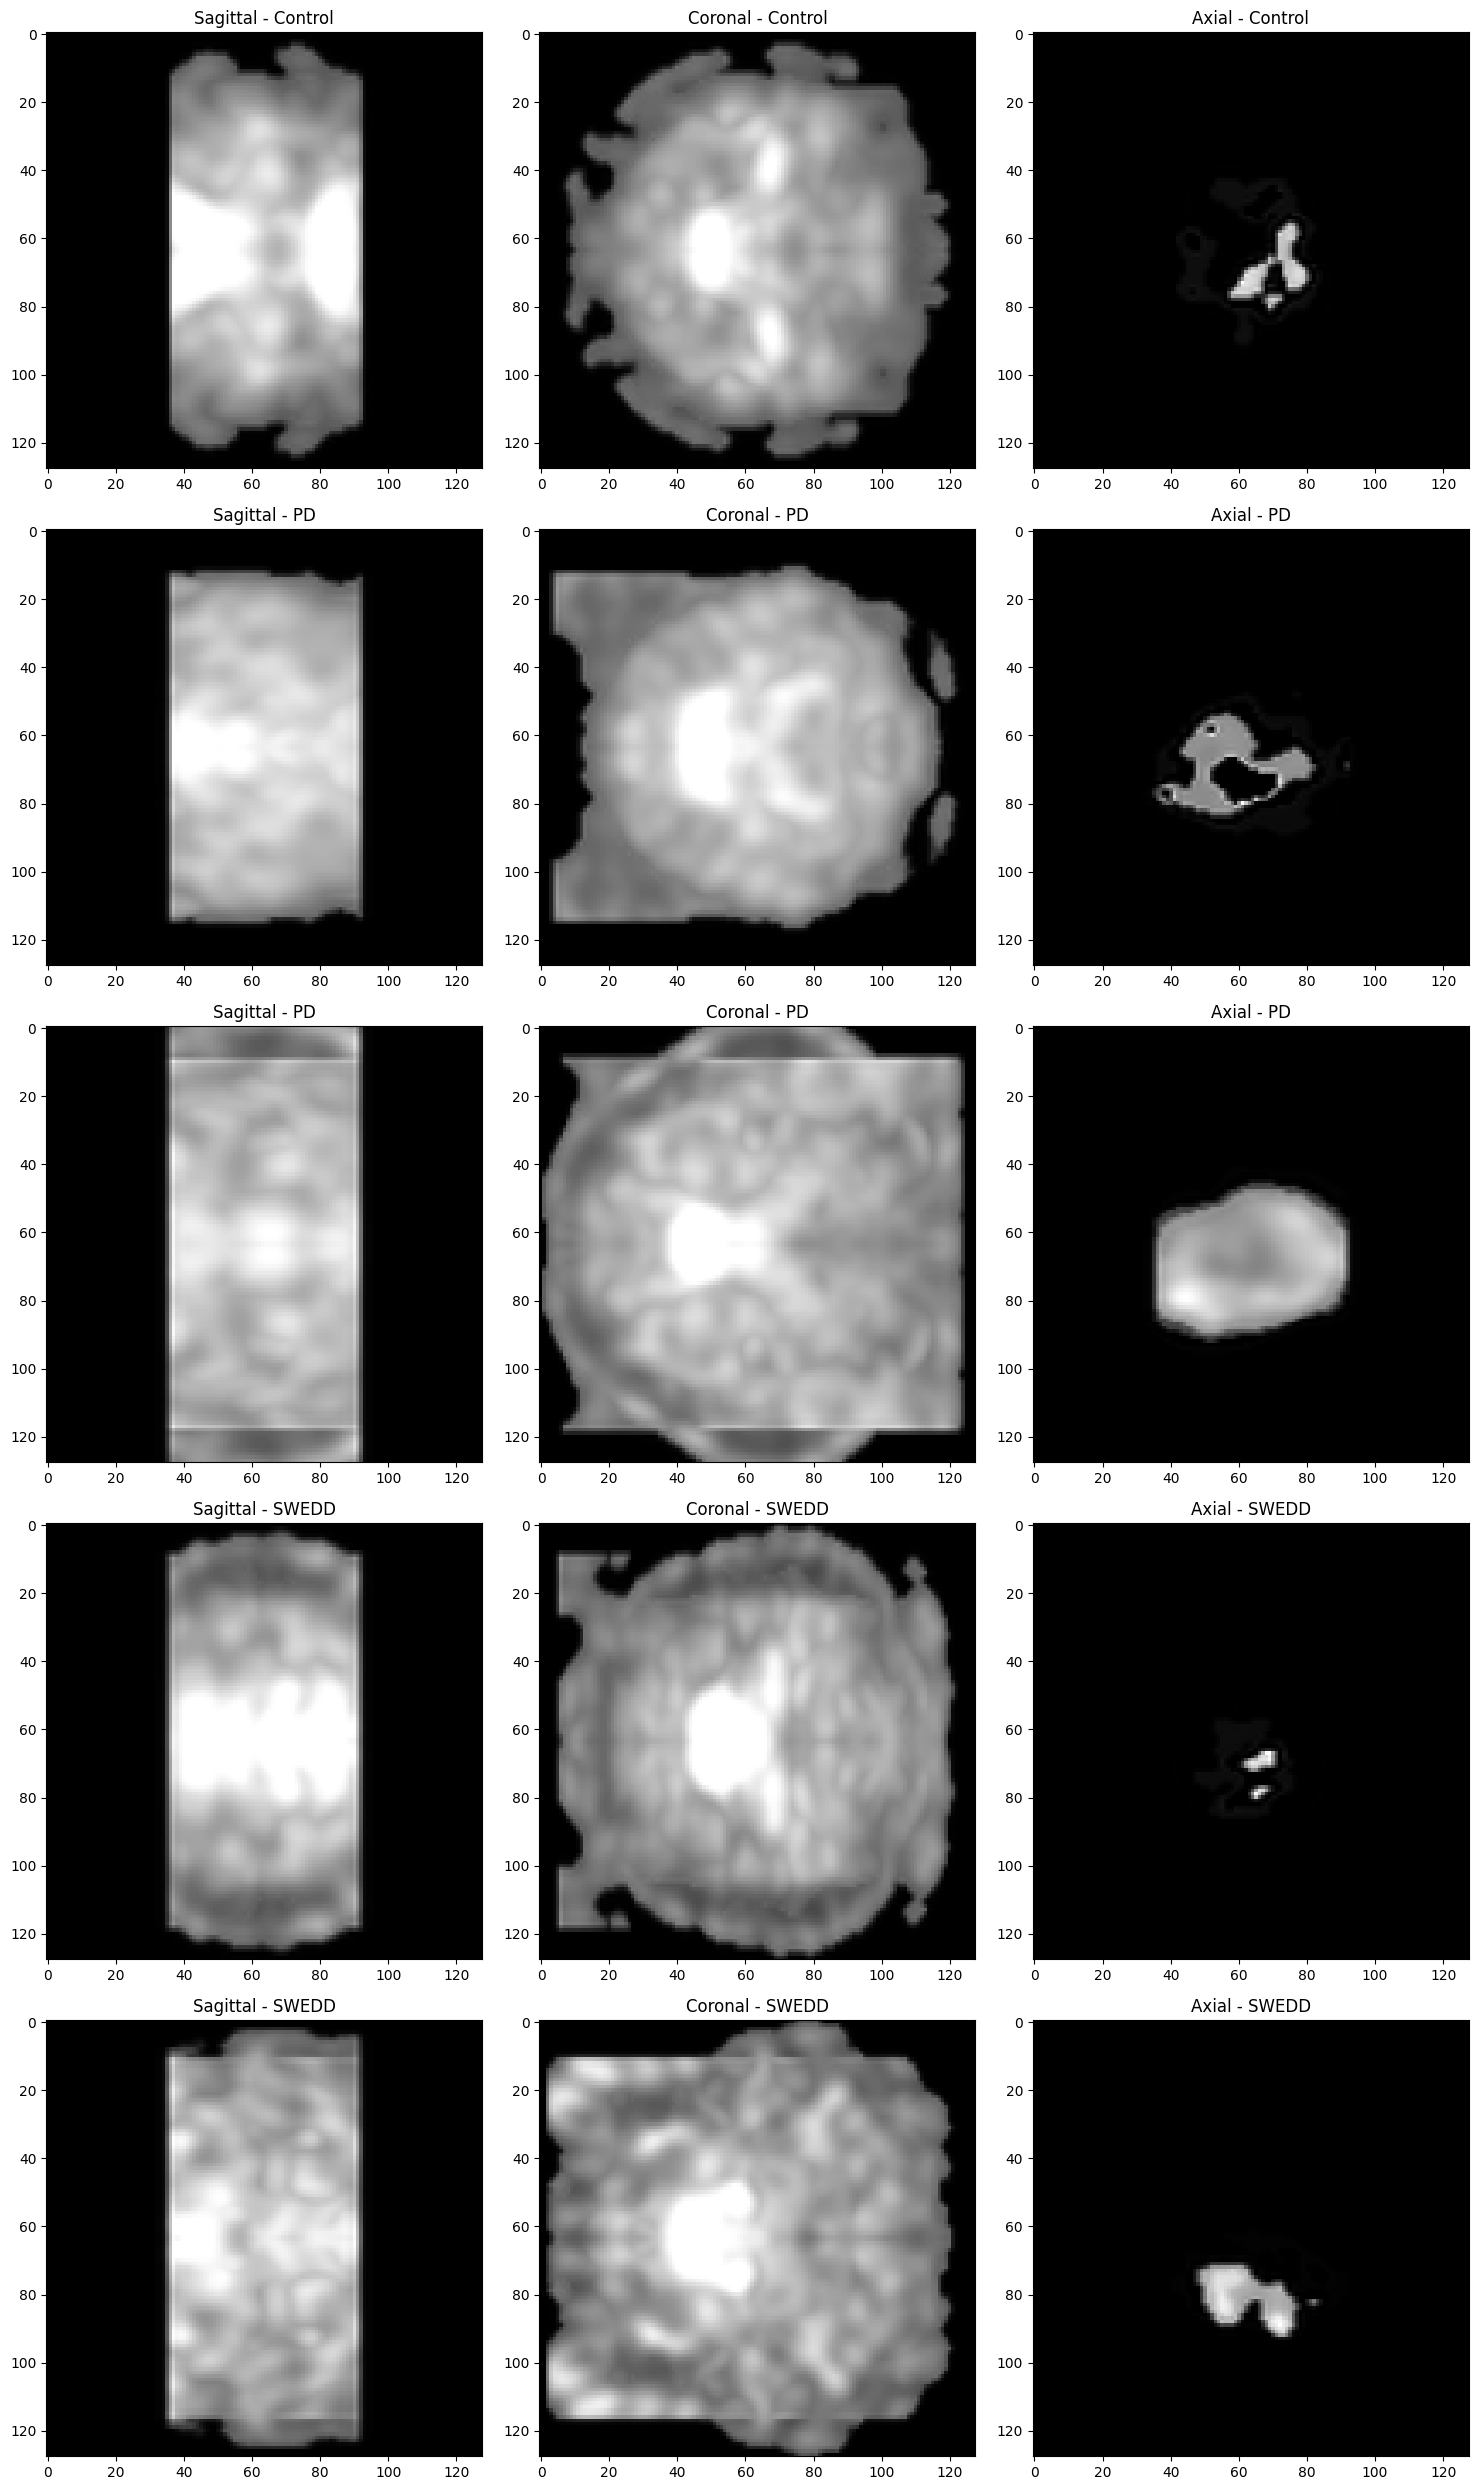


Processing complete dataset...

Computing dataset statistics...


Computing statistics:   0%|          | 0/598 [00:00<?, ?batch/s]

In [ ]:
# Cell 29: Run Complete Preprocessing Pipeline

def run_complete_preprocessing(df):
    print("\nInitializing complete preprocessing pipeline...")
    
    # Initialize preprocessor
    preprocessor = DATSCANPreprocessor(
        target_shape=(128, 128, 128),
        batch_size=4,
        augment=True
    )
    
    # Validate preprocessing on a small subset
    validate_preprocessing(preprocessor, df)
    
    # Process all data if validation looks good
    user_input = input("\nDoes the preprocessing validation look correct? (yes/no): ")
    if user_input.lower() == 'yes':
        print("\nProcessing complete dataset...")
        preprocessor.process_and_save(df)
        print("\nPreprocessing complete!")
    else:
        print("\nPreprocessing cancelled. Please adjust parameters and try again.")

# Execute the pipeline
if __name__ == "__main__":
    run_complete_preprocessing(df)

#### Nota da sviluppare: codice evita le immagini con dimensioni diverse dalle altre (per il tensore).

# Modeling (TUTTO DA TESTARE DA QUI)

In [ ]:
# Cell 30: Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Cell 31: Model Architectures

class Encoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        
        # Convolutional layers for 3D images (128x128x128)
        self.encoder = nn.Sequential(
            # Level 1: 128x128x128 -> 64x64x64
            nn.Conv3d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2),
            
            # Level 2: 64x64x64 -> 32x32x32
            nn.Conv3d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2),
            
            # Level 3: 32x32x32 -> 16x16x16
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2),
            
            # Level 4: 16x16x16 -> 8x8x8
            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2),
            
            # Level 5: 8x8x8 -> 4x4x4
            nn.Conv3d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2)
        )
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers to latent space
        self.fc = nn.Linear(512 * 4 * 4 * 4, latent_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        
        # Initial fully connected layer
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4 * 4)
        
        # Reshape layer
        self.reshape = lambda x: x.view(-1, 512, 4, 4, 4)
        
        # Deconvolutional layers
        self.decoder = nn.Sequential(
            # Level 1: 4x4x4 -> 8x8x8
            nn.ConvTranspose3d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            
            # Level 2: 8x8x8 -> 16x16x16
            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            
            # Level 3: 16x16x16 -> 32x32x32
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            
            # Level 4: 32x32x32 -> 64x64x64
            nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            
            # Level 5: 64x64x64 -> 128x128x128
            nn.ConvTranspose3d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in range [0,1]
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = self.reshape(x)
        return self.decoder(x)

class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = Encoder(latent_dim * 2)  # *2 for mean and logvar
        
        # Decoder
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # Decode
        recon = self.decoder(z)
        
        return recon, mu, logvar

In [ ]:
# Cell 32: Training Functions

def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss function combining reconstruction loss and KL divergence
    """
    # Reconstruction loss (binary cross entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + beta * KLD

class VAETrainer:
    def __init__(self, model, device, train_loader, val_loader=None, 
                 learning_rate=1e-4, beta=1.0):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.beta = beta
        
    def train_epoch(self):
        self.model.train()
        train_loss = 0
        
        for batch_idx, data in enumerate(tqdm(self.train_loader, desc="Training")):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, logvar = self.model(data)
            
            # Compute loss
            loss = vae_loss_function(recon_batch, data, mu, logvar, self.beta)
            
            # Backward pass
            loss.backward()
            train_loss += loss.item()
            
            # Update weights
            self.optimizer.step()
            
        return train_loss / len(self.train_loader.dataset)
    
    def validate(self):
        self.model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for data in self.val_loader:
                data = data.to(self.device)
                recon_batch, mu, logvar = self.model(data)
                val_loss += vae_loss_function(recon_batch, data, mu, logvar, self.beta).item()
                
        return val_loss / len(self.val_loader.dataset)
    
    def train(self, epochs):
        train_losses = []
        val_losses = []
        
        for epoch in range(1, epochs + 1):
            train_loss = self.train_epoch()
            train_losses.append(train_loss)
            
            if self.val_loader is not None:
                val_loss = self.validate()
                val_losses.append(val_loss)
                print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
            else:
                print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}')
        
        return train_losses, val_losses

In [ ]:
# Cell 33: Data Loading and Model Training

def load_preprocessed_data(data_dir='preprocessed_data'):
    """Load preprocessed data and create data loaders"""
    # Load statistics
    stats = torch.load(os.path.join(data_dir, 'statistics.pt'))
    
    # Create train and validation datasets
    train_data = []
    val_data = []
    
    # Load training data
    train_dir = os.path.join(data_dir, 'train')
    for batch_file in os.listdir(train_dir):
        data = torch.load(os.path.join(train_dir, batch_file))
        train_data.append(data['images'])
    
    # Load validation data
    val_dir = os.path.join(data_dir, 'val')
    for batch_file in os.listdir(val_dir):
        data = torch.load(os.path.join(val_dir, batch_file))
        val_data.append(data['images'])
    
    # Concatenate all batches
    train_data = torch.cat(train_data, dim=0)
    val_data = torch.cat(val_data, dim=0)
    
    return train_data, val_data, stats

def train_vae_model(train_data, val_data, batch_size=8, epochs=50, latent_dim=64):
    """Train the VAE model"""
    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VAE(latent_dim=latent_dim)
    
    # Train model
    trainer = VAETrainer(model, device, train_loader, val_loader)
    train_losses, val_losses = trainer.train(epochs)
    
    return model, train_losses, val_losses

In [ ]:
# Cell 34: Visualization Functions

def plot_losses(train_losses, val_losses):
    """Plot training and validation losses"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

def visualize_reconstructions(model, data_loader, device, num_images=5):
    """Visualize original and reconstructed images"""
    model.eval()
    with torch.no_grad():
        # Get some random images
        data_iter = iter(data_loader)
        data = next(data_iter)[:num_images].to(device)
        
        # Reconstruct images
        recon, _, _ = model(data)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
        for i in range(num_images):
            # Original
            axes[0, i].imshow(data[i, 0, data.shape[2]//2].cpu(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original')
            
            # Reconstructed
            axes[1, i].imshow(recon[i, 0, recon.shape[2]//2].cpu(), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed')
        
        plt.tight_layout()
        plt.show()

In [ ]:
# Cell 35: Main Training Pipeline
def main():
    print("Loading preprocessed data...")
    train_data, val_data, stats = load_preprocessed_data()
    
    print("\nTraining VAE model...")
    model, train_losses, val_losses = train_vae_model(
        train_data, 
        val_data,
        batch_size=8,
        epochs=50,
        latent_dim=64
    )
    
    print("\nPlotting training curves...")
    plot_losses(train_losses, val_losses)
    
    print("\nVisualizing reconstructions...")
    val_loader = DataLoader(val_data, batch_size=8, shuffle=True)
    visualize_reconstructions(model, val_loader, next(model.parameters()).device)
    
    # Save model
    print("\nSaving model...")
    torch.save(model.state_dict(), 'vae_model.pt')
    print("Done!")

if __name__ == "__main__":
    main()